# **Case: 2025 Recommendation for Internal Capital Deployment**

### *Preliminaries*

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy import stats
from scipy.stats import gaussian_kde
from numba import njit
from statsmodels.graphics.tsaplots import plot_acf
import random

%matplotlib inline

In [20]:
# Fetch data from GitHub repository
!mkdir -p data

!wget -O data/spy_daily_2020-2024.csv \
https://raw.githubusercontent.com/ludvig-a-stromberg/stress-testing-investment-strategy/refs/heads/main/data/spy_daily_2020-2024.csv

!wget -O data/DFEDTARL_2020-2024.csv \
https://raw.githubusercontent.com/ludvig-a-stromberg/stress-testing-investment-strategy/refs/heads/main/data/DFEDTARL_2020-2024.csv

!wget -O data/DFEDTARU_2020-2024.csv \
https://raw.githubusercontent.com/ludvig-a-stromberg/stress-testing-investment-strategy/refs/heads/main/data/DFEDTARU_2020-2024.csv

--2025-12-05 20:50:10--  https://raw.githubusercontent.com/ludvig-a-stromberg/stress-testing-investment-strategy/refs/heads/main/data/spy_daily_2020-2024.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30089 (29K) [text/plain]
Saving to: ‘data/spy_daily_2020-2024.csv’

data/spy_daily_2020 100%[===================>]  29.38K  --.-KB/s    in 0.003s  

2025-12-05 20:50:10 (10.0 MB/s) - ‘data/spy_daily_2020-2024.csv’ saved [30089/30089]

--2025-12-05 20:50:10--  https://raw.githubusercontent.com/ludvig-a-stromberg/stress-testing-investment-strategy/refs/heads/main/data/DFEDTARL_2020-2024.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.git

#### Plot Settings

In [21]:
sns.reset_orig()
plt.rcdefaults()

In [22]:
# Seaborn
#sns.set_style("darkgrid")                     # 'white', 'dark', whitegrid', 'darkgrid'
#sns.set_context("notebook", font_scale=0.95)  # 'paper', 'notebook', 'talk', 'poster' (finest --> coarsest)
sns.set_palette("deep")

# Matplotlib
#plt.rcParams["lines.linewidth"] = 1.75
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", sns.color_palette())
plt.rcParams['axes.titlesize'] = 14       # subplot titles
plt.rcParams['figure.titlesize'] = 16     # suptitle

#### Functions

In [23]:
def marginal_density_line_plot(scenarios, title='', xlabel='', ylabel='', size=(10, 5), grid=False):
  """
  Generates a line plot of scenario paths with appended marginal density
  """
  # colors
  y_t = scenarios[-1]
  vmin, vmax = np.percentile(y_t, [1, 99])    # clip extremes for nicer contrast
  norm = Normalize(vmin=vmin, vmax=vmax)
  cmap = plt.colormaps["viridis"]
  # figure
  fig, ax = plt.subplots(figsize=size)
  ax.set_title(title)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.spines[['right', 'top']].set_visible(False)
  ax.set_xlim(right=len(scenarios))
  if grid:
    ax.grid(alpha=0.35)
  for i in range(N):
      ax.plot(scenarios[:, i], lw=1.0, alpha=0.5, color=cmap(norm(y_t[i])))
  # density
  kde = gaussian_kde(y_t)
  y_grid = np.linspace(y_t.min(), y_t.max(), 1000)
  density = kde(y_grid)
  # density axis
  ax_in = ax.inset_axes([0.973, 0.0, 0.2, 1.0], transform=ax.transAxes)
  ax_in.axis("off")
  ax_in.set_ylim(ax.get_ylim())
  for j in range(len(y_grid) - 1):
      y0, y1 = y_grid[j], y_grid[j + 1]
      y_mid = 0.5 * (y0 + y1)
      ax_in.fill_betweenx([y0, y1], 0, density[j:j+2], alpha=0.5, color=cmap(norm(y_mid)))
  plt.tight_layout()
  plt.show()
  return

def Ravel(x):
  x = np.asarray(x)
  if x.ndim == 2 and 1 in x.shape:
    return x.ravel()
  return x

def bootstrap(returns, s0, T, basis, n_paths=1, seed=None):
  if seed is not None:
    np.random.seed(seed)
  returns = Ravel(returns)
  n_steps = int(round(T * basis))
  sampled = np.random.choice(returns, size=(n_steps, n_paths), replace=True)
  paths = s0 * np.exp(np.vstack([np.zeros(n_paths), np.cumsum(sampled, axis=0)]))
  return paths

def generate_gbm(mu=0.08, sigma=0.2, x0=100, T=5.0, basis=252, n_paths=1, seed=None):
  """
  Generates GBM path on a discrete basis:
    X_{t+Δ​t} = X_t ​exp((μ - 1/2 σ^2)Δt + σ √(Δt)Z_t),  Z_t ∼ N(0,1)
  ---
  mu: drift (annual)
  sigma: volatility (annual)
  x0: initial condition
  T: terminal time in years
  basis: steps per year (e.g. daily: 252, weekly: 52, monthly: 12, yearly: 1)
  """
  if seed is not None:
    np.random.seed(seed)
  n =  int(round(T * basis))
  dt = T / n
  t = np.linspace(0, T, n+1)
  X = np.empty([n+1, n_paths])
  for i in range(n_paths):
    Z = np.random.normal(0, 1, size=n)
    Wt = np.concatenate(([0], np.cumsum(np.sqrt(dt) * Z)))
    X[:, i] = x0 * np.exp((mu - 0.5*sigma**2)*t + sigma*Wt)
  return X

def buy_and_hold(w, price, r, initial_wealth=100, basis=252, continuous=False, return_all=False):
  """
  Simulate a buy-and-hold strategy
  ---
  prop: proportion initialized in shares
  price: price data (vector)
  r: risk-free rate data (annual) (constant or vector)
  initial_wealth: starting capital of the strategy portfolio
  basis: times per year in the data (e.g. daily: 252, weekly: 52, monthly: 12, yearly: 1)
  continuous: continuous time compounding logic (hint: theoretical math or real-world simulation)
  """
  T = len(price)
  r = np.exp(r / basis) - 1 if continuous else (1 + r) ** (1 / basis) - 1
  r = np.broadcast_to(r, (T,))

  shares = w * initial_wealth / price[0]
  cash   = (1 - w) * initial_wealth

  # preallocate
  risky_value = np.empty(T)
  cash_value  = np.empty(T)
  wealth      = np.empty(T)

  risky_value[0] = shares * price[0]
  cash_value[0]  = cash
  wealth[0]      = initial_wealth

  for t in range(1, T):
      # state at start of t
      cash *= np.exp(r[t-1]) if continuous else (1 + r[t-1])
      risky_value[t] = shares * price[t]
      cash_value[t]  = cash
      wealth[t]      = risky_value[t] + cash_value[t]

  if return_all:
    return wealth, risky_value, cash_value
  else:
    return wealth

def constant_mix(w, price, r, initial_wealth=100, trading_cost=0.0, basis=252, continuous=False, return_all=False):
  """
  Simulate a constant mix strategy
  ---
  w: constant proportion in shares
  price: price data (vector)
  r: risk-free rate data (constant or vector)
  initial_wealth: starting capital of the strategy portfolio
  trading_cost: fee rate per amount traded
  basis: times per year in the data (e.g. daily: 252, weekly: 52, monthly: 12, yearly: 1)
  continuous: continuous time compounding logic (hint: theoretical math or real-world simulation)
  """
  T = len(price)
  r = np.exp(r / basis) - 1 if continuous else (1 + r) ** (1 / basis) - 1
  r = np.broadcast_to(r, (T,))


  shares = w * initial_wealth / price[0]
  cash = (1 - w) * initial_wealth

  # preallocate
  risky_value = np.empty(T)
  cash_value  = np.empty(T)
  wealth      = np.empty(T)

  risky_value[0] = shares * price[0]
  cash_value[0]  = cash
  wealth[0]      = initial_wealth

  for t in range(1, T):
      # state at start of t
      cash *= np.exp(r[t-1]) if continuous else (1 + r[t-1])
      risky_value[t] = shares * price[t]
      cash_value[t]  = cash
      wealth[t]      = risky_value[t] + cash_value[t]

      # trade / rebalance
      target_risky_value = w * wealth[t]
      trade_amount       = target_risky_value - risky_value[t]
      delta_shares       = trade_amount / price[t]
      fee                = abs(trade_amount) * trading_cost

      shares            += delta_shares
      cash              -= fee + trade_amount

      risky_value[t] = shares * price[t]
      cash_value[t]  = cash
      wealth[t]     -= fee

  if return_all:
    return wealth, risky_value, cash_value
  else:
    return wealth

def cppi(m, floor, price, r, initial_wealth=100, trading_cost=0.0, basis=252, leverage=False, ratchet=False, continuous=False, return_all=False):
  """
  Simulate a constant proportion portfolio insurance strategy
  ---
  m: multiplier (scalar)
  floor: floor, interpreted as protected amount at horizon (scalar)
  price: price data (vector)
  r: nominal annualized free rate data (scalar or vector)
  initial_wealth: starting capital of the strategy portfolio
  trading_cost: fee rate per amount traded
  basis: times per year in the data (e.g. daily: 252, weekly: 52, monthly: 12, yearly: 1)
  leverage: allow negative positions, i.e. borrowing / shorting
  ratchet: ratchet floor
  continuous: continuous time compounding logic (hint: theoretical math or real-world simulation)
  """
  T = len(price)
  r = np.exp(r / basis) - 1 if continuous else (1 + r) ** (1 / basis) - 1
  r = np.broadcast_to(r, (T,))

  t = np.arange(T)
  floor = floor * np.exp(-r * (T-1-t)) if continuous else floor / (1 + r)**(T-1-t)

  shares = m * (initial_wealth - floor[0]) / price[0]
  cash = initial_wealth - shares * price[0]

  # preallocate
  cushion     = np.empty(T)
  risky_value = np.empty(T)
  cash_value  = np.empty(T)
  wealth      = np.empty(T)

  cushion[0]     = initial_wealth - floor[0]
  risky_value[0] = shares * price[0]
  cash_value[0]  = cash
  wealth[0]      = initial_wealth

  for t in range(1, T):
      # state at start of t
      cash          *= np.exp(r[t-1]) if continuous else (1 + r[t-1])
      risky_value[t] = shares * price[t]
      cash_value[t]  = cash
      wealth[t]      = risky_value[t] + cash_value[t]
      if ratchet is not False:
        floor[t]     = np.maximum(floor[t-1], ratchet * wealth[t])
      cushion[t]     = wealth[t] - floor[t] if leverage else np.maximum(wealth[t] - floor[t], 0)

      # trade / rebalance
      target_risky_value = m * cushion[t] if leverage else np.minimum(m * cushion[t], wealth[t])
      trade_amount       = target_risky_value - risky_value[t]
      delta_shares       = trade_amount / price[t]
      fee                = abs(trade_amount) * trading_cost

      shares            += delta_shares
      cash              -= fee + trade_amount

      risky_value[t] = shares * price[t]
      cash_value[t]  = cash
      wealth[t]     -= fee

  if return_all:
    return wealth, floor, cushion, risky_value, cash_value
  else:
    return wealth

def strategy_monte_carlo(scenarios, initial_wealth=100_000, basis=252, bh_prop=0.8, cm_prop=0.8, m=3, floor_prop=0.8, rate=0.025, strategies=["BH", "CM", "CPPI"]):
  """
  Simulates BH, CM, and CPPI strategies from scenario file of price paths.
  ---
  scenarios  : scanrios of market prices (array) (time x n_scenarios)
  basis      : times per year in the data (e.g. daily: 252, weekly: 52, monthly: 12, yearly: 1)
  floor_prop : CPPI floor in proportion of initial wealth
  ---
  scenarios: nump y array of scenarios of shape (Time, Scenario)
  """
  T, N  = scenarios.shape
  floor = floor_prop * initial_wealth
  BH    = np.empty((T, N))
  CM    = np.empty((T, N))
  CPPI  = np.empty((T, N))
  for i in range (N):
    if "BH" in strategies:
      BH[:,i]   = buy_and_hold(bh_prop, scenarios[:,i], rate, initial_wealth, basis=basis)
    if "CM" in strategies:
      CM[:,i]   = constant_mix(cm_prop, scenarios[:,i], rate, initial_wealth, basis=basis)
    if "CPPI" in strategies:
      CPPI[:,i] = cppi(m, floor, scenarios[:,i], rate, initial_wealth, basis=basis)

  return BH, CM, CPPI

def summary_table(arr, name='Summary'):
  summary = {
      "mean": np.mean(arr),
      "std": np.std(arr),
      "skew": pd.Series(arr).skew(),
      "kurtosis": pd.Series(arr).kurtosis(),
      "p01": np.percentile(arr, 1),
      "p05": np.percentile(arr, 5),
      "p25": np.percentile(arr, 25),
      "p50": np.percentile(arr, 50),
      "p75": np.percentile(arr, 75),
      "p95": np.percentile(arr, 95),
      "p99": np.percentile(arr, 99),
      "min": np.min(arr),
      "max": np.max(arr)
  }
  return pd.DataFrame(summary, index=[name])

def CAGR(R, T):
  """
  Computes the mean CAGR for a set of returns
  ---
  R: return data (array)
  T: number of years
  """
  return (np.mean(1 + R)) ** (1 / T) - 1

def Sortino(R, r):
  """
  Computes the sortino ratio of a set of returns with respect to a target return

    DD = √(1/n Σ_i^n min(0, r - t)^2)
  ---
  R: return data (array)
  r: target minimum acceptable return (scalar or array)
  """
  r = np.broadcast_to(r, (len(R),))                  # scalar compatability with time dependent series
  DD = np.sqrt(np.mean(np.minimum(0, R - r) ** 2))   # downside deviation
  return np.mean(R - r) / DD

def Omega(R, r):
  """
  Computes omega ratio of a set of returns with respect to a threshold return.
  ---
  R: return series
  r: threshold required return
  """
  r = np.broadcast_to(r, (len(R),))
  return np.sum(np.maximum(0, R - r)) / np.sum(np.maximum(0, r - R))

def UpsidePotentialRatio(r, MAR):
  """
  Computes the Upside Potential Ratio
     E[(r - MAR)^+] / √(E[(r - MAR)^2])
  ---
  r: returns
  MAR: Minimum Acceptable Return, threshold for excess returns
  """
  Pr = 1 / len(r)
  return np.sum(r[r > MAR] - MAR) * Pr / np.sqrt(np.sum((r[r < MAR] - MAR)**2) * Pr)

def sensitivity_sim(strategies, mu, sigma, s0, rf_rate, T, basis, n_paths, target_return, seed=None):
  prices = generate_gbm(mu, sigma, s0, T, basis, n_paths, seed=seed)
  sim = {}
  for name, types in strategies.items():
    if name == "BH":
      for type_, param in types.items():
        sim[f'{name}_{type_}'], _, _ = strategy_monte_carlo(prices, V0, basis, bh_prop=param, cm_prop=0.8, m=3, floor_prop=0.8, rate=rf_rate, strategies=name)
    elif name == "CM":
      for type_, param in types.items():
        _, sim[f'{name}_{type_}'], _ = strategy_monte_carlo(prices, V0, basis, bh_prop=0.8, cm_prop=param, m=3, floor_prop=0.8, rate=rf_rate, strategies=name)
    elif name == "CPPI":
      for type_, (m, floor) in types.items():
        _, _, sim[f'{name}_{type_}'] = strategy_monte_carlo(prices, V0, basis, bh_prop=0.8, cm_prop=0.8, m=m, floor_prop=floor, rate=rf_rate, strategies=name)

  returns       = {name: strategy[-1] / strategy[0] - 1 for name, strategy in sim.items()}
  df = pd.concat([summary_table(paths, name=name) for name, paths in returns.items()]).drop(columns=['mean', 'skew', 'kurtosis', 'min', 'max']).rename(columns={"std": "vol", 'p50': 'Median'})
  # add performance metrics
  for strategy in sim:
      wealth                          = sim[strategy]
      losses                          = wealth[0] - wealth[-1]
      df.loc[strategy, 'VaR']         = np.percentile(losses, 95)
      df.loc[strategy, 'ES']          = np.mean(losses[losses >= df.loc[strategy, 'VaR']])
      df.loc[strategy, 'P[Wt < 90%]'] = np.mean(np.any(wealth < 0.90 * wealth[0], axis=0))
      df.loc[strategy, 'E[rT]']       = np.mean(returns[strategy])
      df.loc[strategy, 'P[rT > 8%]']  = np.mean(returns[strategy] > 0.08)
      #df.loc[strategy, 'Sortino']    = Sortino(returns[strategy], target_return)
      df.loc[strategy, 'Omega']       = Omega(returns[strategy], target_return)
      df.loc[strategy, 'UPR']         = UpsidePotentialRatio(returns[strategy], target_return)

  return sim, returns, df

def tornado(ax, data_low, data_mid, data_high, factor=None):
  # parameter df
  param_df = pd.concat([data_low, data_mid, data_high], axis=1)
  param_df.columns = ['Low', 'Mid', 'High']
  order = np.argsort(np.abs(param_df.loc[:,'High'].values - param_df.loc[:,'Low'].values))
  ordered_labels = param_df.index[order]
  # ordered high and low ranges
  high = param_df.loc[ordered_labels,'High'].values - param_df.loc[ordered_labels, 'Mid'].values
  low  = param_df.loc[ordered_labels,'Low'].values  - param_df.loc[ordered_labels, 'Mid'].values

  if factor is not None:
    label1 = f'{factor}↑'
    label2 = f'{factor}↓'
  else:
    label1 = label2 = factor

  ax.barh(ordered_labels, high, color='steelblue', alpha=0.7, label=label1)
  ax.barh(ordered_labels, low, color='firebrick', alpha=0.7, label=label2)
  ax.axvline(0, color='black', linewidth=1)
  ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)
  return

def bandplot_from_series(ax, data_low, data_mid, data_high):
    labels = data_mid.index.to_list()
    lows   = data_low.values
    mids   = data_mid.values
    highs  = data_high.values

    y = np.arange(len(labels))

    ax.hlines(y, lows, highs, color='skyblue', zorder=1, alpha=0.6, linewidth=3)
    ax.plot(mids, y, 'o', zorder=2)
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.axvline(0, color='black', linewidth=1, alpha=0.3)
    ax.spines[['top','right','left','bottom']].set_visible(False)
    ax.grid(axis='x', alpha=0.2)
    return

def format_df(df: pd.DataFrame, format: dict):
    """
    Pure value-level formatting.
    Applies formatting templates to specified columns.
    ---
    fmt: format map, e.g. {col: "{:.2f}", col2: "${:,.0f}", ...}
    """
    df2 = df.copy(deep=True)
    for col, fmt in format.items():
        if col in df2.columns:
            df2[col] = df2[col].map(lambda x: fmt.format(x))
    return df2

def style_df(df, cmap=None, align=False, format=None, width=None, height=None):
  """
  cmap   : color map coding (str or dict)
  align  : cell and column alignment ('left', 'center', 'right')
  format : format map ({col: format, ...}, where format is on the form of e.g. "{:.2f}" for 2 decimap places, "${:,.0f}" for intiger currency format, etc.).
  width  : table width (e.g. '80px', '100px')
  height  : table height (e.g. '20px', '40px')
  ---
  returns: Styler
  """
  df2 = df.copy()
  sty = df2.style
  # color map
  if cmap is not None:
    if isinstance(cmap, str):
      subset = df2.columns
      sty = sty.background_gradient(cmap=cmap, subset=subset)
    else:
      subsets = list(cmap.values())
      if len(set().union(*subsets)) != sum(len(subset) for subset in subsets):
        print('WARNING: Columns in cmap overlap, ealier colorings will be overwritten with the later\n')
      for color, subset in cmap.items():
        sty = sty.background_gradient(cmap=color, subset=subset)
  # align
  if align is not False:
    sty = sty\
      .set_properties(**{'text-align': align})\
      .set_table_styles([{'selector': 'th', 'props': [('text-align', align)]}])
  # format
  if format is not None:
    sty = sty.format(format)
  # size
  if width is not None:
    sty = sty.set_properties(**{'width': width})
  if height is not None:
    sty = sty.set_properties(**{'height': height})

  return sty

def range_df(df1, df2, format=None, align='center'):
  """
  Creates a range table of the cell values from two DataFrames with identical columnns and indexes.
  ---
  format: format map ({col: lambda x: format}, where format is on the form of e.g. "{:.2f}" for 2 decimap places, "${:,.0f}" for intiger currency format, etc.)
  """
  if format is None:
    print("\033[31mError\033[0m: Must provide argument: format\n")
  out = pd.DataFrame(index=df1.index)
  # format
  for col in df1.columns:
    out[col] = df1[col].apply(format[col]) + " → " + df2[col].apply(format[col])
  if align is not None:
    out = style_df(out, align=align)
  return out

def breach_df(df, constraints, style=True, align=False, format=None):
  """
  Creates breach table from df and constraints matching the coloumns df.
  ---
  df          : (Pandas DataFrmae)
  constraints : dict on the form {col: (threshold, direction), ...}, where col must be at least a subset of columns from df, threshold is the value, and direction is in ('le', 'eq', 'ge')
  format      : format map ({col: lambda x: format}, where format is on the form of e.g. "{:.2f}" for 2 decimap places, "${:,.0f}" for intiger currency format, etc.)
  """
  breaches = pd.DataFrame(index=df.index)
  # breaches
  for col in constraints:
    if constraints[col][1] == 'le':
      breaches[col] = np.maximum(df[col] - constraints[col][0], 0)
    elif constraints[col][1] == 'ge':
      breaches[col] = np.maximum(constraints[col][0] - df[col], 0)
    elif constraints[col][1] == 'eq':
      breaches[col] = abs(df[col] - constraints[col][0])
  # style
  if style:
    cmap = 'Reds'
  else:
    cmap = None
  breaches = style_df(breaches, cmap=cmap, align=align, format=format)
  return breaches


def escape_latex(df: pd.DataFrame):
    df2 = df.copy(deep=True)
    # columns
    df2.columns = [
          col.replace('%', r'\%').replace('$', r'\$').replace('_', r'\_')
          if isinstance(col, str) else col
          for col in df2.columns
      ]
    # index
    df2.index = [
        ind.replace('%', r'\%').replace('$', r'\$').replace('_', r'\_')
        if isinstance(ind, str) else ind
        for ind in df2.index
    ]
    # cells
    def esc(val):
        if isinstance(val, str):
            return val.replace('%', r'\%').replace('$', r'\$').replace('_', r'\_')
        return val
    return df2.map(esc)

## Scenario

As of 2024-12-31, SEB's Treasury and Risk Control divisions must determine portion of the bank's surplus liquidity should be allocated for the 2025 operating year. The recent environment post-COVID-19 consists of macro-political uncertainty, economic downturns, and simultaneous strong market expansions. The portfolio will support internal capital buffers, liquidity coverage, and capital efficiency preferences in order to protect balance-sheet resilience while not forgoing upside participation.

As such, the portfolio has received certain internal objectives on Value-at-Risk $\left(\text{VaR}\right)$, Expected Shortfall $\left(\text{ES}\right)$, as well as probabilistic goals for running capital levels $\left(W_t\right)$ and terminal return $\left(r_T\right)$, The starting capital amount is $\$1,000,000$, and the portfolio has the following objectives to the end of 2025$^1$:

1.   $\text{VaR}_{95\%} \qquad\qquad\qquad\qquad\, \le \$120\,000$,
2.   $\text{ES}_{95\%} \qquad\qquad\qquad\qquad\;\;\;\, \le \$150\,000$,
3.   $\mathbb{P}\left(W_t \ \text{breaching} \ \$900,000 \right) \le 25\%$,
4.   $\mathbb{E}\left[r_T\right] \qquad\qquad\qquad\qquad\quad \ge 5\%$,
5.   $\mathbb{P}\left(r_T \geq 8\%\right) \qquad\qquad\qquad\; \ge 40\%$.

Beyond these objectives, we make general analytical risk-performance assessments in order to gain comprehensive understandings and make holistic delineations. We will be investing in one risky and one riskless asset class and our task is to recommend the strategy that best supports the bank's objectives.

<small>
$^1$ We account this case in USD for convention and convenience
<small>

## 1. Data & Scenario Calibration

We will assume SPY as our risky investment, and obtain data (retrieved from Yahoo Finance) from the recent 5 year period—2020 through 2024—initializing our projective analysis at the start of 2025. We use this data estimate realistic expected future conditions, equity drift and volatility. In order to infer how sensitive our analysis is to different future possibilities, we create two scenarios in addition to the baseline expectation: (1) a recession scenario based on the segment in year 2022, and (2) an expansion scenario based on the segment in year 2024. These expansion/recession conditions will be assumed as best/worst-case scenarios to assess the robustness and profile of the strategies and their analysis.

Further, we let the Federal Funds Rate (FFR) imply expected risk-free rate of returns. We obtain current data from FRED and projections of the FFR targets from the [Summary of Economic Projections](https://www.federalreserve.gov/monetarypolicy/fomcprojtabl20241218.htm) (SEP) issued by the Federal Open Market Committee (FMOC) on December 18, 2024. We use the current upper and lower target bounds to compute the current median FFR target, and use linear interpolation to get a smooth transition from today's level (4.4\%) to the projected level at the end of 2025 (3.9\%). This captures the committee's expectations of policy and macro-structures, and this FFR forecast will represent the expected short rate, which we let approximate the short-term risk-free asset returns (e.g. from rolling Treasury Bills). Further, we set a high-rate scenario transitioning up to 5\% and a low-rate scenario down to 1% for sensitivity testing on interest rate risk. These are rate levels that have been observed in the recent years.

In [24]:
# SPY data
spy = pd.read_csv("data/spy_daily_2020-2024.csv", index_col="Date")          # daily
spy.index = pd.to_datetime(spy.index)
spy = spy.resample("W-FRI").last().dropna()                                  # weekly, weeks ends friday

# FFR Data
ffr_u = pd.read_csv("data/DFEDTARU_2020-2024.csv", index_col="Date") / 100
ffr_u.index = pd.to_datetime(ffr_u.index)
ffr_u = ffr_u.loc[ffr_u.index < "2025-01-01"].iloc[-1]                       # current upper
ffr_l = pd.read_csv("data/DFEDTARL_2020-2024.csv", index_col="Date") / 100
ffr_l.index = pd.to_datetime(ffr_l.index)
ffr_l = ffr_l.loc[ffr_l.index < "2025-01-01"].iloc[-1]                       # current lower
ffr_0 = np.mean([ffr_l, ffr_u])                                              # current median

In [25]:
# ------ Market Parameters ------
recession = spy.loc['2022-01-01':'2023-01-01']
expansion = spy.loc['2024-01-01':]

# Expected Scenario
ret       = np.log(spy).diff().dropna()
vol       = np.std(ret.values, ddof=1) * np.sqrt(52)      # annualized
m         = np.mean(ret) * 52                             # annualized

# Recession Scenario
ret_rec   = np.log(recession).diff().dropna()
vol_rec   = np.std(ret_rec.values, ddof=1) * np.sqrt(52)  # annualized
m_rec     = np.mean(ret_rec) * 52                         # annualized

# Expansion Scenario
ret_exp = np.log(expansion).diff().dropna()
vol_exp   = np.std(ret_exp.values, ddof=1) * np.sqrt(52)  # annualized
m_exp     = np.mean(ret_exp) * 52                         # annualized

# Market (GBM) Parameters
sigma, sigma_rec, sigma_exp = vol, vol_rec, vol_exp       # Var[r] = sigma^2
mu     = m     + 0.5 * sigma ** 2                         # E[r] = mu - 1/2 sigma^2
mu_rec = m_rec + 0.5 * sigma ** 2
mu_exp = m_exp + 0.5 * sigma ** 2

# ----------- FFR -----------
# SEP FFR Target 2025
ffr      = 3.9 / 100
#ffr_low  = 2.5 / 100  # low rate scenario
#ffr_high = 5.3 / 100

ffr_low  = 1.0 / 100  # low rate scenario
ffr_high = 5.0 / 100  # high rate scenario

# FFR Forecast Path (Linear Interpolation) (weekly)
rf      = ffr_0 - (ffr_0 - ffr)      * np.linspace(0, 1, 52+1)
rf_low  = ffr_0 - (ffr_0 - ffr_low)  * np.linspace(0, 1, 52+1)
rf_high = ffr_0 - (ffr_0 - ffr_high) * np.linspace(0, 1, 52+1)

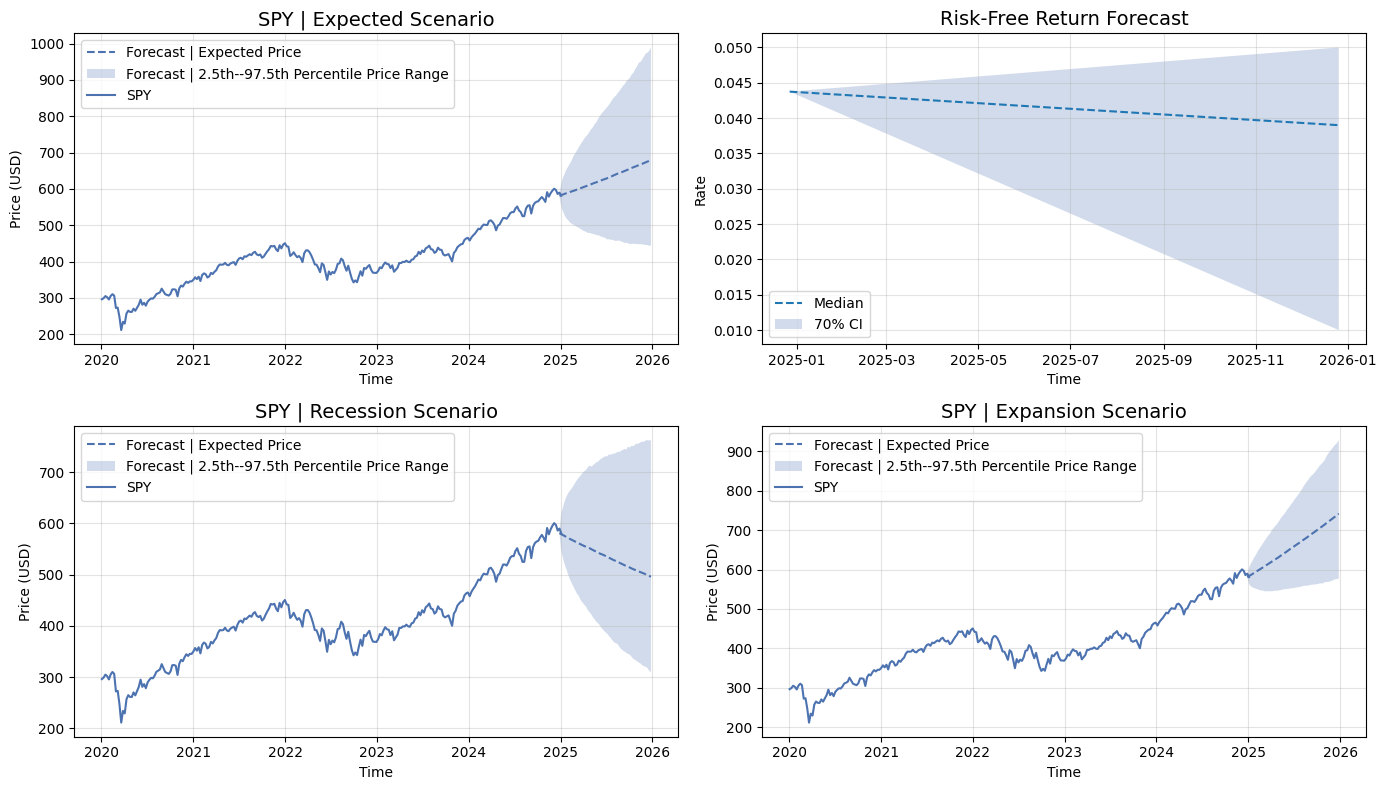

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(14, 8))
ax = ax.ravel()

ax[0].set_title("SPY | Expected Scenario")
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Price (USD)')
ax[0].grid(alpha=0.35)
dates = pd.date_range(start='2024-12-27', end='2025-12-31', freq='W-FRI')
bs = bootstrap(ret.values, spy.values[-1], 1.0, 52, n_paths=10_000, seed=9)
ax[0].plot(dates, np.mean(bs, axis=1), color=sns.color_palette('deep', n_colors=1)[0], linestyle='--', label='Forecast | Expected Price')
ax[0].fill_between(dates, np.percentile(bs, 97.5, axis=1), np.percentile(bs, 2.5, axis=1), alpha=0.25, label='Forecast | 2.5th--97.5th Percentile Price Range')
ax[0].plot(spy, label='SPY')
ax[0].legend()

ax[1].set_title("Risk-Free Return Forecast")
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Rate')
ax[1].grid(alpha=0.35)
ax[1].plot(dates, rf, color='tab:blue', linestyle='--', label='Median')
ax[1].fill_between(dates, rf_low, rf_high, alpha=0.25, label='70% CI')
ax[1].legend()

ax[2].set_title("SPY | Recession Scenario")
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Price (USD)')
ax[2].grid(alpha=0.35)
bs = bootstrap(ret_rec.values, spy.values[-1], 1.0, 52, n_paths=10_000, seed=9)
ax[2].plot(dates, np.mean(bs, axis=1), color=sns.color_palette('deep', n_colors=1)[0], linestyle='--', label='Forecast | Expected Price')
ax[2].fill_between(dates, np.percentile(bs, 97.5, axis=1), np.percentile(bs, 2.5, axis=1), alpha=0.25, label='Forecast | 2.5th--97.5th Percentile Price Range')
ax[2].plot(spy, label='SPY')
ax[2].legend()

ax[3].set_title("SPY | Expansion Scenario")
ax[3].set_xlabel('Time')
ax[3].set_ylabel('Price (USD)')
ax[3].grid(alpha=0.35)
bs = bootstrap(ret_exp.values, spy.values[-1], 1.0, 52, n_paths=10_000, seed=9)
ax[3].plot(dates, np.mean(bs, axis=1), color=sns.color_palette('deep', n_colors=1)[0], linestyle='--', label='Forecast | Expected Price')
ax[3].fill_between(dates, np.percentile(bs, 97.5, axis=1), np.percentile(bs, 2.5, axis=1), alpha=0.25, label='Forecast | 2.5th--97.5th Percentile Price Range')
ax[3].plot(spy, label='SPY')
ax[3].legend()

plt.tight_layout()
plt.show()

## 2. Simulation

We simulate SPY prices as a standard geometric Brownian motion, where we derive the regime-specific drift and diffusion parameters from the sample mean return $\bar{r}$ and sample standard deviation of returns $s$ estimated from the respective data periods. We obtain the following scenarios:

*   **Baseline Scenario:** $\{\bar{r} = 13.4\%,\, s = 20.2\%\},$

*   **Recession Year:** $\{\bar{r} = -18.5\%,\, s = 23.2\%\},$

*   **Expansion Year:** $\{\bar{r} = 23.8\%\,\, s = 12.3\%\}.$
<br>

We consider a range of Buy-and-Hold (BH) as well as Constant Proportion Portfolio Insurance (CPPI) strategies to analyze how the strategies perform. The proportions for the BH's are 40/60, 60/40, 80/20, and 100/0, and the CPPI multipliers are 2, 3, 4, and 5. Since it is our objective is to have $\text{VaR} \le \$120,000$, we let the floor of the CPPI's be (the present value of) $\$880,000$. We trade/reallocate weekly, and assume that transaction costs and other unaddressed market frictions are negligible.

In [27]:
seed    = 9
N       = 100_000              # number of simulations
T       = 1.0                  # terminal year
basis   = 52                   # steps per year
V0      = 1_000_000            # initial wealth
s0      = spy.values[-1]       # start on latest market price

strategies = {
    "BH": {
        "40": 0.4,
        "60": 0.6,
        "80": 0.8,
        "100": 1.0
    },
    #"CM": {
    #    "40": 0.4,
    #    "60": 0.6,
    #    "80": 0.8
    #},
    "CPPI": {
        "2": (2, 0.88),
        "3": (3, 0.88),
        "4": (4, 0.88),
        "5": (5, 0.88)
    }
}

# GBM
prices = generate_gbm(mu, sigma, s0, T, basis, n_paths=N, seed=seed)

# Monte Carlo
sim = {}
for name, types in strategies.items():
  if name == "BH":
    for type_, param in types.items():
      sim[f'{name}_{type_}'], _, _ = strategy_monte_carlo(prices, V0, basis, bh_prop=param, cm_prop=0.8, m=3, floor_prop=0.8, rate=rf, strategies=name)
  elif name == "CM":
    for type_, param in types.items():
      _, sim[f'{name}_{type_}'], _ = strategy_monte_carlo(prices, V0, basis, bh_prop=0.8, cm_prop=param, m=3, floor_prop=0.8, rate=rf, strategies=name)
  elif name == "CPPI":
    for type_, (m, floor) in types.items():
      _, _, sim[f'{name}_{type_}'] = strategy_monte_carlo(prices, V0, basis, bh_prop=0.8, cm_prop=0.8, m=m, floor_prop=floor, rate=rf, strategies=name)

Example Strategy Visual

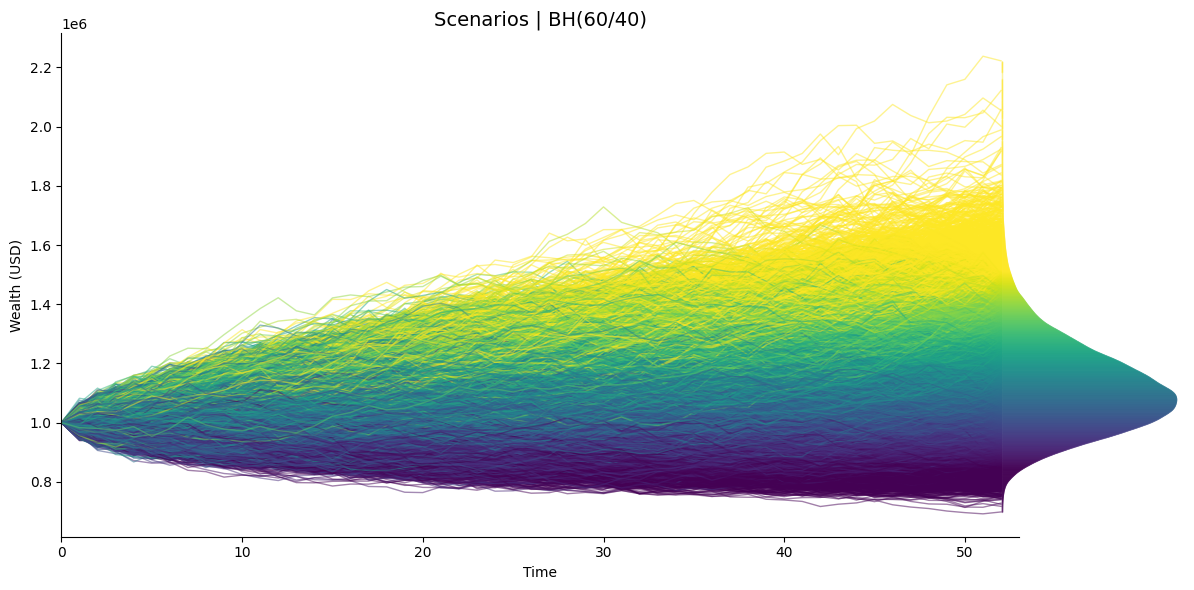

In [28]:
marginal_density_line_plot(sim['BH_60'], title='Scenarios | BH(60/40)', xlabel='Time', ylabel='Wealth (USD)', size=(12, 6))

**Statistics & Performance Metrics**

In [29]:
returns       = {name: strategy[-1] / strategy[0] - 1 for name, strategy in sim.items()}
target_return = 0.05

df = pd.concat([summary_table(paths, name=name) for name, paths in returns.items()]).drop(columns=['mean', 'skew', 'kurtosis', 'min', 'max']).rename(columns={"std": "vol", 'p50': 'Median'})
# add performance metrics
for strategy in sim:
    wealth                          = sim[strategy]
    losses                          = wealth[0] - wealth[-1]
    df.loc[strategy, 'VaR']         = np.percentile(losses, 95)
    df.loc[strategy, 'ES']          = np.mean(losses[losses >= df.loc[strategy, 'VaR']])
    df.loc[strategy, 'P[Wt < 90%]'] = np.mean(np.any(wealth < 0.9 * wealth[0], axis=0))
    df.loc[strategy, 'E[rT]']       = np.mean(returns[strategy])
    df.loc[strategy, 'P[rT > 8%]']  = np.mean(returns[strategy] > 0.08)
    #df.loc[strategy, 'Sortino']    = Sortino(returns[strategy], target_return)
    df.loc[strategy, 'Omega']       = Omega(returns[strategy], target_return)
    df.loc[strategy, 'UPR']         = UpsidePotentialRatio(returns[strategy], target_return)

df.style.\
      background_gradient(cmap="PuBu").\
      background_gradient(cmap='PuBu_r', subset=['vol', 'VaR', 'ES', 'P[Wt < 90%]']).\
      format("{:.3f}").\
      set_properties(**{'width': '80px', 'height': '20px'})

,vol,p01,p05,p25,Median,p75,p95,p99,VaR,ES,P[Wt < 90%],E[rT],P[rT > 8%],Omega,UPR
BH_40,0.095,-0.089,-0.048,0.023,0.082,0.149,0.263,0.356,47676.136,73228.834,0.017,0.091,0.507,3.168,1.539
BH_60,0.143,-0.155,-0.092,0.014,0.102,0.203,0.373,0.514,92224.090,130553.136,0.123,0.116,0.563,3.449,1.643
BH_80,0.191,-0.220,-0.137,0.005,0.122,0.257,0.484,0.671,136772.043,187877.438,0.245,0.141,0.591,3.600,1.699
BH_100,0.239,-0.285,-0.181,-0.004,0.142,0.311,0.594,0.828,181319.996,245201.741,0.342,0.166,0.608,3.694,1.733
CPPI_2,0.086,-0.048,-0.025,0.022,0.067,0.126,0.244,0.357,24638.410,38659.052,0.000,0.083,0.432,2.978,1.588
CPPI_3,0.145,-0.075,-0.051,0.005,0.069,0.166,0.400,0.615,51353.616,65679.292,0.001,0.106,0.462,3.326,1.863
CPPI_4,0.190,-0.093,-0.073,-0.014,0.066,0.219,0.510,0.741,72861.113,85343.035,0.023,0.126,0.466,3.349,1.974
CPPI_5,0.213,-0.105,-0.089,-0.032,0.071,0.261,0.555,0.793,89040.400,98845.230,0.086,0.137,0.486,3.245,1.964


### Sensitivity Analysis

In [30]:
sim_r_low , returns_r_low  , df_r_low  = sensitivity_sim(strategies, mu, sigma, s0, rf_low, T, basis, n_paths=N, target_return=target_return, seed=seed)
sim_r_high, returns_r_high , df_r_high = sensitivity_sim(strategies, mu, sigma, s0, rf_high, T, basis, n_paths=N, target_return=target_return, seed=seed)

sim_rec   , returns_rec    , df_rec    = sensitivity_sim(strategies, mu_rec, sigma, s0, rf, T, basis, n_paths=N, target_return=target_return, seed=seed)
sim_exp   , returns_exp    , df_exp    = sensitivity_sim(strategies, mu_exp, sigma, s0, rf, T, basis, n_paths=N, target_return=target_return, seed=seed)

scenarios = {
    'rf': (df_r_low, df_r_high),
    'mu': (df_rec, df_exp)
     }
factors = [
    'VaR',
    'ES',
    'P[Wt < 90%]',
    'Median',
    'E[rT]',
    'P[rT > 8%]',
    'Omega',
    'UPR'
    ]
names = {
    'BH'  : ['BH_40', 'BH_60', 'BH_80', 'BH_100'],
    #'CM'  : ['CM_40', 'CM_60', 'CM_80'],
    'CPPI': ['CPPI_2', 'CPPI_3', 'CPPI_4', 'CPPI_5'],
}
objectives = {
    'VaR'         : 120_000,
    'ES'          : 150_000,
    'P[Wt < 90%]' : 0.25,
    'Median'      : None,
    'E[rT]'       : 0.05, #(1 + 0.05) * 1_000_000,
    'P[rT > 8%]'  : 0.40,
    'Omega'       : None,
    'UPR'         : None
}
obj_cols = ['VaR', 'ES', 'P[Wt < 90%]', 'Median', 'E[rT]', 'P[rT > 8%]', 'Omega', 'UPR']

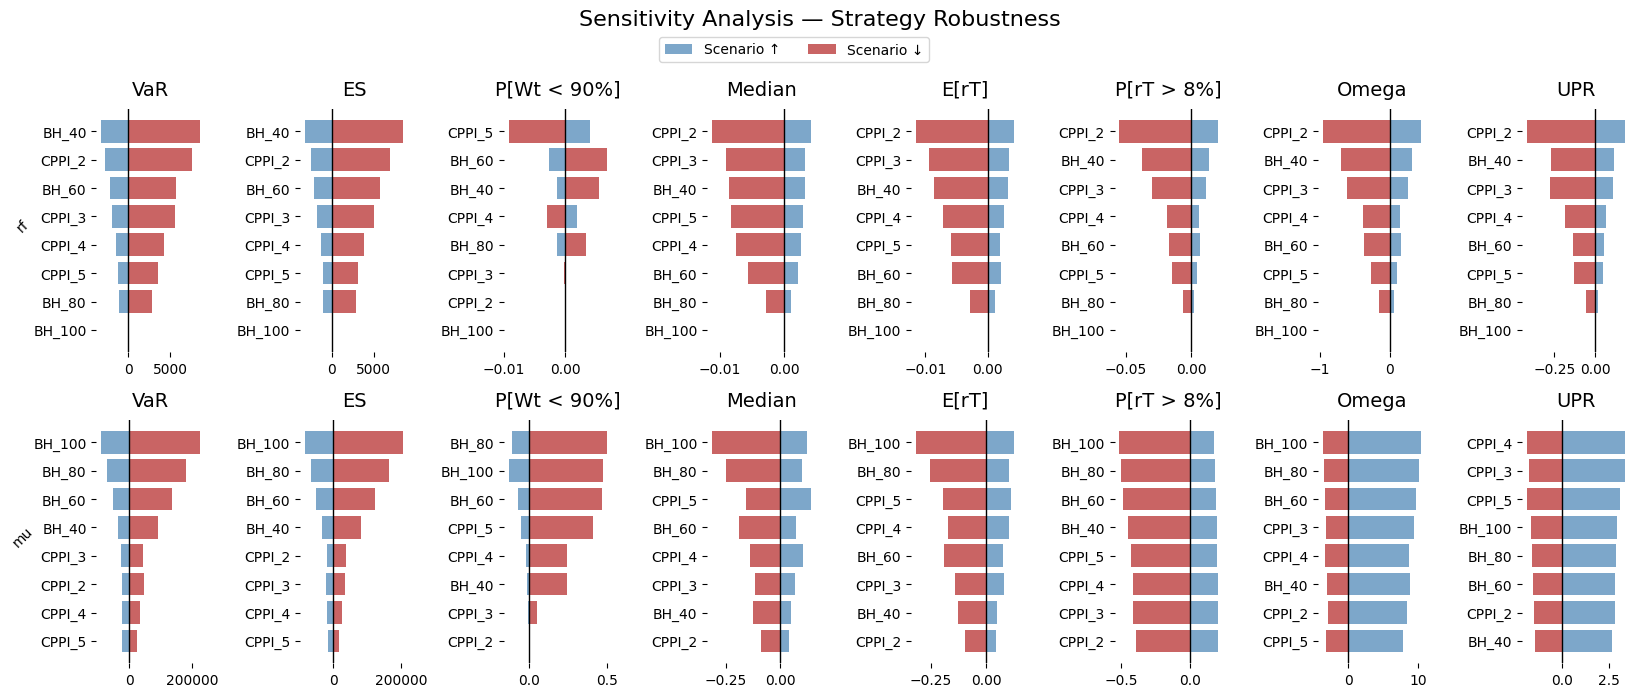

In [31]:
fig, axes = plt.subplots(len(scenarios), len(factors), figsize=(16.5, 7))
fig.suptitle("Sensitivity Analysis — Strategy Robustness", y=0.99)
if len(scenarios) == 1:
    axes = np.array([axes])
if len(factors) == 1:
    axes = axes.reshape(-1, 1)
for i, (scenario, (low_df, high_df)) in enumerate(scenarios.items()):
    for j, factor in enumerate(factors):
        ax = axes[i, j]
        ax.set_title(f"{factor}", pad=10)
        tornado(ax, low_df[factor], df[factor], high_df[factor], factor=scenario)
        if j == 0:
            ax.set_ylabel(f"{scenario}", rotation=45)
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, [f'Scenario ↑', f'Scenario ↓'], bbox_to_anchor=(0.57, 0.96), ncol=len(handles))
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.show()

## 3. Results

In addition to the objective metrics, we track the Omega ratio and the Upside Potential ratio (UPR) of the strategies to get an additional cohesive point of view on the efficiency of the upside vs downside potential. The Omega ratio will indicate the favorability of the whole distribution from tail to tail, whereas UPR focuses on the expected upside capture per unit of downside risk Since we have the expected return objective of 5%, we use this as the MAR when computing both ratios.

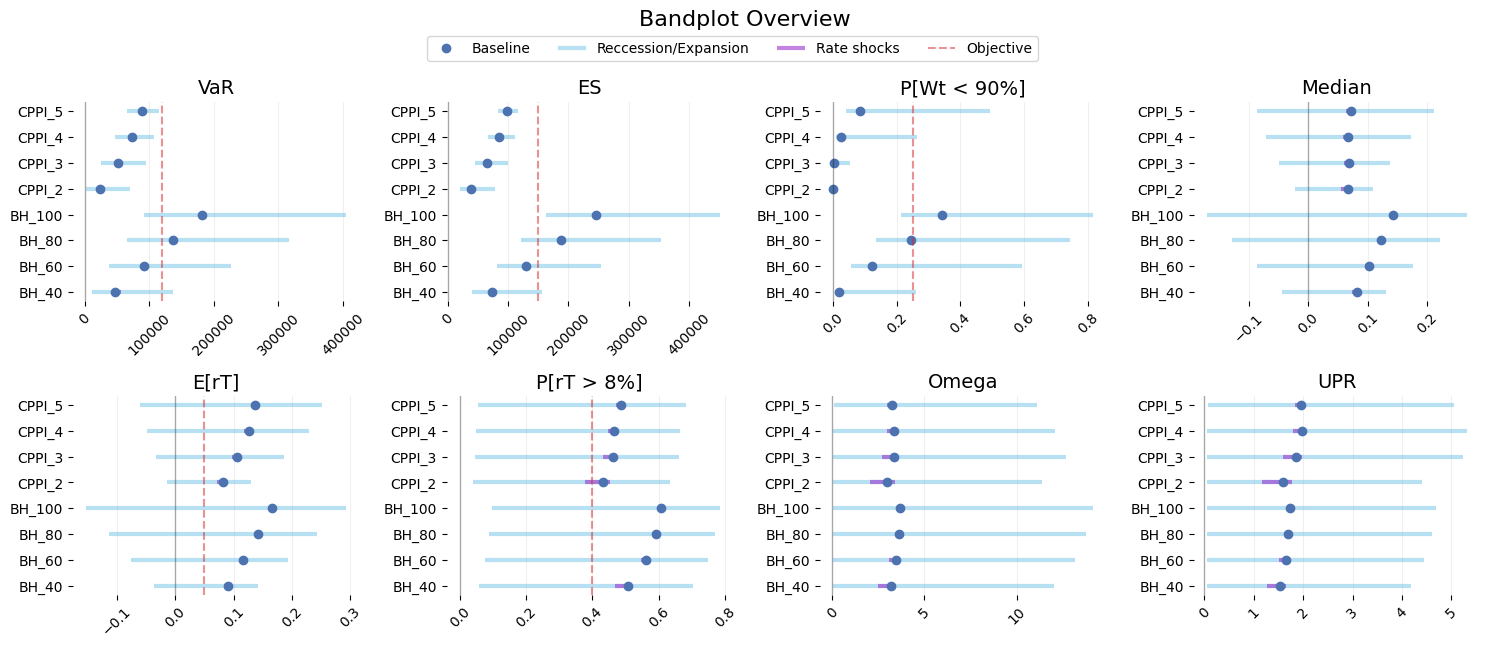

In [32]:
survivors = ['BH_40', 'BH_60', 'BH_80', 'BH_100', 'CPPI_2', 'CPPI_3', 'CPPI_4', 'CPPI_5']

fig, ax = plt.subplots(2, 4, figsize=(15, 6.5))
ax = ax.ravel()
for i, (metric, (objective, target)) in enumerate(zip(factors, objectives.items())):
  labels =  df.loc[survivors, metric].index.to_list()
  y = np.arange(len(labels))
  ax[i].plot(df.loc[survivors, metric].values, y, 'o', zorder=2, label='Baseline')
  ax[i].hlines(y, df_rec.loc[survivors, metric].values, df_exp.loc[survivors, metric].values, color='skyblue', zorder=1, alpha=0.6, linewidth=3, label='Reccession/Expansion')
  ax[i].hlines(y, df_r_low.loc[survivors, metric].values, df_r_high.loc[survivors, metric].values, color='darkorchid', zorder=1, alpha=0.6, linewidth=3, label='Rate shocks')
  ax[i].set_yticks(y)
  ax[i].set_yticklabels(labels)
  ax[i].axvline(0, color='black', linewidth=1, alpha=0.3)
  ax[i].spines[['top','right','left','bottom']].set_visible(False)
  ax[i].grid(axis='x', alpha=0.2)
  if objective == metric and target is not None:
      ax[i].axvline(x=target, linestyle='--', color='tab:red', alpha=0.5, label='Objective')
  ax[i].set_title(f"{metric}")
  ax[i].tick_params(axis='x', labelrotation=45)
fig.suptitle(f"Bandplot Overview", y=0.99)
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.7, 0.96), ncol=len(handles))
fig.tight_layout(rect=[0, 0, 1, 0.96])
#plt.savefig('bandplot.png')
plt.show()

### Baseline Table:

In [33]:
fmt = {'VaR': "${:,.0f}", 'ES': "${:,.0f}", 'P[Wt < 90%]': "{:.1%}", 'Median': "{:.1%}", 'E[rT]': "{:.1%}", 'P[rT > 8%]': "{:.1%}", 'Omega': "{:.3f}", 'UPR': "{:.3f}"}
obj_cmap = {'PuBu'   : [x for x in list(df[obj_cols].columns) if x not in ['VaR', 'ES', 'P[Wt < 90%]']], 'PuBu_r' :['VaR', 'ES', 'P[Wt < 90%]']}
style_df(df[obj_cols], cmap=obj_cmap, format=fmt, width='100px')

,VaR,ES,P[Wt < 90%],Median,E[rT],P[rT > 8%],Omega,UPR
BH_40,"$47,676","$73,229",1.7%,8.2%,9.1%,50.7%,3.168,1.539
BH_60,"$92,224","$130,553",12.3%,10.2%,11.6%,56.3%,3.449,1.643
BH_80,"$136,772","$187,877",24.5%,12.2%,14.1%,59.1%,3.600,1.699
BH_100,"$181,320","$245,202",34.2%,14.2%,16.6%,60.8%,3.694,1.733
CPPI_2,"$24,638","$38,659",0.0%,6.7%,8.3%,43.2%,2.978,1.588
CPPI_3,"$51,354","$65,679",0.1%,6.9%,10.6%,46.2%,3.326,1.863
CPPI_4,"$72,861","$85,343",2.3%,6.6%,12.6%,46.6%,3.349,1.974
CPPI_5,"$89,040","$98,845",8.6%,7.1%,13.7%,48.6%,3.245,1.964


### Range Table:

In [34]:
range_fmt = {'VaR': lambda x: f"${x:,.0f}", 'ES': lambda x: f"${x:,.0f}", 'P[Wt < 90%]': lambda x: f"{x:.1%}", 'Median': lambda x: f"{x:.1%}",
             'E[rT]': lambda x: f"{x:.1%}", 'P[rT > 8%]': lambda x: f"{x:.1%}", 'Omega': lambda x: f"{x:.3f}", 'UPR': lambda x: f"{x:.3f}",}
range_df(df_rec[obj_cols], df_exp[obj_cols], range_fmt)

,VaR,ES,P[Wt < 90%],Median,E[rT],P[rT > 8%],Omega,UPR
BH_40,"$137,223 → $11,872","$155,789 → $40,219",26.0% → 0.5%,-4.3% → 13.2%,-3.6% → 14.2%,5.9% → 70.2%,0.055 → 12.056,0.046 → 4.177
BH_60,"$226,545 → $38,518","$254,393 → $81,038",59.3% → 5.6%,-8.6% → 17.7%,-7.5% → 19.3%,7.8% → 74.8%,0.060 → 13.185,0.050 → 4.455
BH_80,"$315,866 → $65,164","$352,997 → $121,857",74.4% → 13.6%,-12.8% → 22.2%,-11.4% → 24.3%,8.9% → 77.1%,0.063 → 13.794,0.053 → 4.601
BH_100,"$405,188 → $91,810","$451,601 → $162,676",81.8% → 21.5%,-17.0% → 26.7%,-15.3% → 29.3%,9.6% → 78.5%,0.065 → 14.175,0.054 → 4.691
CPPI_2,"$70,161 → $2,410","$77,547 → $19,650",0.0% → 0.0%,-2.2% → 11.0%,-1.3% → 12.9%,4.0% → 63.3%,0.051 → 11.362,0.044 → 4.418
CPPI_3,"$94,409 → $25,795","$99,821 → $45,350",5.4% → 0.0%,-4.8% → 13.8%,-3.4% → 18.6%,4.8% → 66.2%,0.056 → 12.669,0.050 → 5.230
CPPI_4,"$107,622 → $47,714","$110,983 → $66,759",26.5% → 0.8%,-7.0% → 17.2%,-4.9% → 22.8%,4.9% → 66.5%,0.062 → 12.087,0.057 → 5.320
CPPI_5,"$114,440 → $66,377","$116,265 → $83,301",49.4% → 3.9%,-8.7% → 21.2%,-6.0% → 25.2%,5.5% → 68.2%,0.070 → 11.136,0.065 → 5.059


### Constraint Breach Table (Recession):

In [35]:
breach_objectives = {'VaR': (120_000, 'le'), 'ES': (150_000, 'le'), 'P[Wt < 90%]': (0.25, 'le'), 'E[rT]': (0.05, 'ge'), 'P[rT > 8%]': (0.4, 'ge')}
breach_df(df_rec, breach_objectives, style=True, align='center', format=range_fmt)

,VaR,ES,P[Wt < 90%],E[rT],P[rT > 8%]
BH_40,"$17,223","$5,789",1.0%,8.6%,34.1%
BH_60,"$106,545","$104,393",34.3%,12.5%,32.2%
BH_80,"$195,866","$202,997",49.4%,16.4%,31.1%
BH_100,"$285,188","$301,601",56.8%,20.3%,30.4%
CPPI_2,$0,$0,0.0%,6.3%,36.0%
CPPI_3,$0,$0,0.0%,8.4%,35.2%
CPPI_4,$0,$0,1.5%,9.9%,35.1%
CPPI_5,$0,$0,24.4%,11.0%,34.5%


## 4. Conclusion

We find that $\text{BH(100)}$ and $\text{BH(80)}$ violate the downside constraints (1, 2 and 3), while $\text{BH(60)}$ quickly fails as market conditions worsen, and $\text{BH(40)}$ marginally fails only in the most egregious prospective case. $\text{CPPI(5)}$ and $\text{CPPI(4)}$ risk failing objective 3 specifically, while $\text{CPPI(2)}$ and $\text{CPPI(3)}$ are significantly less sensitive to market stress and are able to comfortably meet the downside risk objectives. We see these risk-profiles reversly mirrored in the upside conditions, where the BH strategies have higher returns. Considering, however, that $\text{BH(100)}$ and $\text{BH(80)}$ are already infeasible, the potential advantage diminishes significantly compared to CPPI strategies. Additionally, all strategies fail to meet both upside objectives in stressed conditions, with $\text{CPPI(2)}$ also risking to fail objective 5 if interest rates see a significant decline back down toward the 1% level. Of the strategies that fulfill the downside risk constraints, $\text{CPPI(3)}$ provides the best upside potential and expected return, whereas $\text{CPPI(2)}$ is overly safe for our risk-appetite and capital-efficiency preferences.

Given the inherent uncertainty of the scenario prospection, mild breaches in the downside constraints may not automatically disqualify $\text{BH(40)}$ as a viable option if it demonstrates advantages that can be deemed to outweigh the significance of the violation margins in this specific case. If we were utilizing a full economic-scenario generator, probability and materiality of such breaches could be better qualified. By contrast, $\text{BH(60)}$ fails at even small to modest instability.

We find that the Omega ratios are better for the BH strategies in general, though most of these are unviable by their amount of downside risk. Omega ratios indicate that $\text{CPPI(3)}$ and $\text{CPPI(4)}$ strike the best balance of expected profit to expected losses among the $\text{CPPI}$'s, with better ratios than $\text{BH(40)}$, and we further see that the upside potential maximizes around $\text{CPPI(4)}$. Both ratios are effectively equally sensitive to scenario conditions for the most part, although for $\text{CPPI(4)}$ and $\text{CPPI(3)}$ have substantially better upside potential than the rest if the market moves toward greater expansion.

It is clear that the marginal benefits in upside exposure are get diminished for subsequently higher risk CPPI's. Therefore, even if we were to still consider $\text{CPPI(4)}$, it is clear under any reasonable interpretation that its stress sensitivity in objective 3 cannot be justified by the slight edge it provides over in the upside. Similarly, $\text{BH(40)}$ does not provide significant advantages over $\text{CPPI(3)}$, apart from a 70 basis points higher expected return and a 3.9 percentage points higher probability of expected return exceeding 8%, but with substantially lower risk-adjusted return metrics and higher sensitivity making it much more likely to violate the downside constraints. We therefore recommend $\text{CPPI(3)}$ as the best viable strategy to support SEB's risk-objectives and maintain exposure to upside potential in 2025.

## 5. Discussion

In an analysis such as this, we could use real risk-free assets (e.g. SGOV) to represent the corresponding returns, but rates have significantly shifted regimes in recent years including just before the end of 2024. In 2020 to 2022 rates were stationarily low just under 0.1\%, and in 2022 there was a rate hike to right above 5\% thorughout 2023 and most of 2024, before just in September starting to decline. This leaves a very poor sample of historical data that could reliably represent how rates are likely to behave going into 2025. Further, as macro-structures are highly relevant in these recent times, this makes a clear advantage to using FMOC's SEP forecast of the FFR, which captures all of the committie's considerations and macro-level projections feeding into their expectations at the policy level. Ultimately, we judge that the discrepancy of treating a short rate object as the actualized returns on tradable risk-free assets is miniscule and far overshadowed by the macro-directional benefit we get from the FFR.

In addition, we considered Constant-Mix (CM) strategies similarly to BH, but the results are so effectively identical to BH that CM was superfluous in analsyis, and consequently dropped.